In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [58]:
image_size = 300
batch_size = 16

In [59]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

train_path_second = '../input/cassava-disease/train/train'

In [60]:
second_id = []
second_label = []

for img in os.listdir(os.path.join(train_path_second, 'cbb')):
    second_id.append('/cbb/'+img)
    second_label.append('0')
    
for img in os.listdir(os.path.join(train_path_second, 'cbsd')):
    second_id.append('/cbsd/'+img)
    second_label.append('1')
    
for img in os.listdir(os.path.join(train_path_second, 'cgm')):
    second_id.append('/cgm/'+img)
    second_label.append('2')
    
for img in os.listdir(os.path.join(train_path_second, 'cmd')):
    second_id.append('/cmd/'+img)
    second_label.append('3')
    
for img in os.listdir(os.path.join(train_path_second, 'healthy')):
    second_id.append('/healthy/'+img)
    second_label.append('4')

In [61]:
train_second = pd.DataFrame({'image_id':second_id, 'label':second_label})

train_second.head()

,image_id,label
0,/cbb/train-cbb-0.jpg,0
1,/cbb/train-cbb-1.jpg,0
2,/cbb/train-cbb-10.jpg,0
3,/cbb/train-cbb-100.jpg,0
4,/cbb/train-cbb-101.jpg,0


In [62]:
del second_id
del second_label

In [63]:
def image_path_first(image):
    return os.path.join(train_path,image)

def image_path_second(image):
    return os.path.join(train_path_second, image)

train['image_id'] = train['image_id'].apply(image_path_first)
train_second['image_id'] = train_second['image_id'].apply(image_path_second)

In [64]:
train['label'] = train['label'].astype('str')

In [65]:
# combine dataframe to train

combined_train = pd.concat([train, train_second], ignore_index=True)

combined_train.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,0
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,1
3,../input/cassava-leaf-disease-classification/t...,1
4,../input/cassava-leaf-disease-classification/t...,3


In [66]:
combined_train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [67]:
del train
del train_second

train = combined_train

del combined_train
del train_path
del train_path_second

In [68]:
train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [69]:
from sklearn.model_selection import StratifiedKFold

SKF = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [70]:
train_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                                horizontal_flip=True, vertical_flip=True, fill_mode='nearest', brightness_range=[0.7, 1.3],
                                rotation_range=270, zoom_range=0.2, shear_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                rescale = 1./255)

val_gen = ImageDataGenerator(rescale=1./255)

In [71]:
def build_efficientnet_b3():
    model = Sequential()
    model.add(EfficientNetB3(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


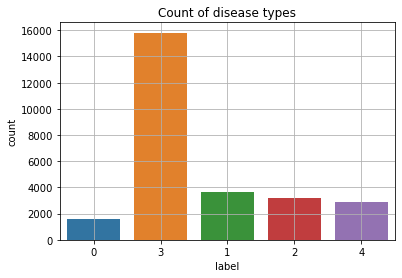

In [16]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of disease types')
plt.grid()
plt.show()

In [17]:
fold_var = 1

In [18]:
for train_idx, val_idx in SKF.split(train, train['label']):
    training_data = train.iloc[train_idx]
    validation_data = train.iloc[val_idx]
    
    # generator
    train_generator = train_gen.flow_from_dataframe(dataframe=training_data, directory=None, x_col='image_id', y_col='label',
                                                batch_size=batch_size, seed=1, shuffle=True,
                                                class_mode='categorical', target_size=(image_size,image_size))

    validation_generator = val_gen.flow_from_dataframe(dataframe=validation_data, directory=None, x_col='image_id', y_col='label',
                                                   batch_size=batch_size, seed=1, shuffle=False,
                                                   class_mode='categorical', target_size=(image_size,image_size))
    
    print('Fold num:', fold_var)
    print('Train length:', len(train_generator))
    print('Val length:', len(validation_generator))
    
    # build model
    model = build_efficientnet_b3()
    
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    
    # callbacks
    checkpoint_filename = './k_folds_model/checkpoint_' + str(fold_var) + '.h5'
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=1, min_lr=0, verbose=1)
    
    # fit
    history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])
                        
    # save model
    model_filename = './k_folds_model/' + str(fold_var) + '.h5'
    model.save(model_filename)
    
    clear_session()
    fold_var += 1

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4547 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17095 validated image filenames belonging to 5 classes.
Found 4302 validated image filenames belonging to 5 classes.
Fold num: 1
Train length: 1069
Val length: 269


C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1109 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/30
1069/1069 [==============================] - ETA: 0s - loss: 0.7885 - accuracy: 0.7233
Epoch 00001: val_loss improved from inf to 1.79104, saving model to ./k_folds_model\checkpoint_1.h5
1069/1069 [==============================] - 389s 364ms/step - loss: 0.7885 - accuracy: 0.7233 - val_loss: 1.7910 - val_accuracy: 0.1188
Epoch 2/30
1069/1069 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.7913
Epoch 00002: val_loss did not improve from 1.79104

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1069/1069 [==============================] - 388s 363ms/step - loss: 0.6051 - accuracy: 0.7913 - val_loss: 2.1064 - val_accuracy: 0.1188
Epoch 3/30
1069/1069 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.8401
Epoch 00003: val_loss did not improve from 1.79104

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1069/1069 [==============================] - 384s 359ms/step - los

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4552 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1104 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17090 validated image filenames belonging to 5 classes.
Found 4307 validated image filenames belonging to 5 classes.
Fold num: 2
Train length: 1069
Val length: 270
Epoch 1/30
1069/1069 [==============================] - ETA: 0s - loss: 0.7644 - accuracy: 0.7339
Epoch 00001: val_loss improved from inf to 1.27421, saving model to ./k_folds_model\checkpoint_2.h5
1069/1069 [==============================] - 392s 366ms/step - loss: 0.7644 - accuracy: 0.7339 - val_loss: 1.2742 - val_accuracy: 0.6167
Epoch 2/30
1069/1069 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7969
Epoch 00002: val_loss did not improve from 1.27421

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1069/1069 [==============================] - 390s 365ms/step - loss: 0.5918 - accuracy: 0.7969 - val_loss: 1.5882 - val_accuracy: 0.3466
Epoch 3/30
1069/1069 [==============================] - ETA: 0s - loss: 0.4695 - accuracy: 0.8414
Epoch 00003: val_loss did not

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4525 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1131 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
Fold num: 3
Train length: 1070
Val length: 268
Epoch 1/30
1070/1070 [==============================] - ETA: 0s - loss: 0.7693 - accuracy: 0.7268
Epoch 00001: val_loss improved from inf to 8.32767, saving model to ./k_folds_model\checkpoint_3.h5
1070/1070 [==============================] - 392s 366ms/step - loss: 0.7693 - accuracy: 0.7268 - val_loss: 8.3277 - val_accuracy: 0.1491
Epoch 2/30
1070/1070 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.7961
Epoch 00002: val_loss improved from 8.32767 to 2.44796, saving model to ./k_folds_model\checkpoint_3.h5
1070/1070 [==============================] - 390s 364ms/step - loss: 0.5971 - accuracy: 0.7961 - val_loss: 2.4480 - val_accuracy: 0.1241
Epoch 3/30
1070/1070 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.8070
Epoch 00003: val_loss did not improve from 2.44796

Epoch 

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4505 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1151 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17138 validated image filenames belonging to 5 classes.
Found 4259 validated image filenames belonging to 5 classes.
Fold num: 4
Train length: 1072
Val length: 267
Epoch 1/30
1072/1072 [==============================] - ETA: 0s - loss: 0.7728 - accuracy: 0.7274
Epoch 00001: val_loss improved from inf to 1.43441, saving model to ./k_folds_model\checkpoint_4.h5
1072/1072 [==============================] - 392s 365ms/step - loss: 0.7728 - accuracy: 0.7274 - val_loss: 1.4344 - val_accuracy: 0.6086
Epoch 2/30
1072/1072 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.7890
Epoch 00002: val_loss did not improve from 1.43441

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1072/1072 [==============================] - 383s 357ms/step - loss: 0.6139 - accuracy: 0.7890 - val_loss: 1.5959 - val_accuracy: 0.1207
Epoch 3/30
1072/1072 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8378
Epoch 00003: val_loss did not

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4495 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1161 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17148 validated image filenames belonging to 5 classes.
Found 4249 validated image filenames belonging to 5 classes.
Fold num: 5
Train length: 1072
Val length: 266
Epoch 1/30
 105/1072 [=>............................] - ETA: 5:24 - loss: 1.0437 - accuracy: 0.6202

ResourceExhaustedError:  OOM when allocating tensor with shape[16,144,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sub_72 (defined at <ipython-input-18-88c43b419a63>:32) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_486072]

Function call stack:
train_function


In [72]:
train_idx, val_idx = [], []

for i in SKF.split(train, train['label']):
    train_idx, val_idx = i

In [73]:
clear_session()

del batch_size
del fold_var

NameError: name 'fold_var' is not defined

In [74]:
training_data = train.iloc[train_idx]
validation_data = train.iloc[val_idx]
    
train_generator = train_gen.flow_from_dataframe(dataframe=training_data, directory=None, x_col='image_id', y_col='label',
                                                batch_size=16, seed=1, shuffle=True,
                                                class_mode='categorical', target_size=(300,300))

validation_generator = val_gen.flow_from_dataframe(dataframe=validation_data, directory=None, x_col='image_id', y_col='label',
                                                   batch_size=16, seed=1, shuffle=False,
                                                   class_mode='categorical', target_size=(300,300))
del train
del train_gen
del val_gen
del training_data
del validation_data
del train_idx
del val_idx
    
print('Fold num: 5')
print('Train length:', len(train_generator))
print('Val length:', len(validation_generator))
    
# build model
model = build_efficientnet_b3()

del image_size
    
# compile
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    
# callbacks   
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('./k_folds_model/checkpoint_5.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=1, min_lr=0, verbose=1)
    
# fit
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])
                        
# save model
model.save('./k_folds_model/5.h5')
    
# evaluate
pred = model.predict(validation_generator)
pred = np.argmax(pred, axis=1)
all_preds.append(pred)
    
clear_session()

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4495 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1161 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17148 validated image filenames belonging to 5 classes.
Found 4249 validated image filenames belonging to 5 classes.
Fold num: 5
Train length: 1072
Val length: 266
Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[16,144,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sub_72 (defined at <ipython-input-74-00c6b5bf148e>:37) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_627159]

Function call stack:
train_function


In [ ]:
test = pd.read_csv('../input/cassava-disease/sample_submission_file.csv')

In [ ]:
test_path = '../input/cassava-disease/test/test/0'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)
test['label'].replace('cbb', '0')
test['label'].replace('cbsd', '1')
test['label'].replace('cgm', '2')
test['label'].replace('cmd', '3')
test['label'].replace('healthy', '4')

In [ ]:
test_generator = val_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.efficientnet.preprocess_input,
                                              class_mode='categorical', target_size=(300,300))

In [ ]:
output = model.predict(test_generator)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(test_generator.classes, output, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

In [ ]:
print(model.predict(load_img('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')))